In [122]:
from pathlib import Path

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

# Setup rng
torch.manual_seed(42)
np.random.seed(42)

In [123]:
# Load images and labels
IMAGES = Path("data/unzipped/images_training_rev1")
data = pd.read_csv("data/unzipped/training_solutions_rev1.csv")

In [124]:
data.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [125]:
# Test loading a single jpg image and getting its data into a numpy array
img = cv2.imread(IMAGES / "100008.jpg")

In [126]:
def image_preprocess(id):
    # Read in the image
    img = cv2.imread(IMAGES / (str(id) + ".jpg"))

    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Crop the image to 192x192 centered on the center pixel
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
    start_x, start_y = center_x - 96, center_y - 96
    img = img[start_y : start_y + 192, start_x : start_x + 192]

    # Downsample to 64x64
    img = cv2.resize(img, (64, 64))

    # Normalize to [0, 1]
    img = img.astype("float32") / 255

    return img


In [127]:
# Load images into numpy array
data["image"] = data["GalaxyID"].apply(lambda x: image_preprocess(x))

In [128]:
data.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6,image
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512,"[[[0.011764706, 0.007843138, 0.0], [0.02352941..."
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000,"[[[0.023529412, 0.007843138, 0.003921569], [0...."
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,"[[[0.050980393, 0.05490196, 0.03529412], [0.01..."
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000,"[[[0.007843138, 0.007843138, 0.0], [0.00392156..."
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,"[[[0.14117648, 0.10980392, 0.02745098], [0.254..."


In [129]:
# Split data into train and test
train, test = train_test_split(data, test_size=0.2)
test, val = train_test_split(test, test_size=0.5)

In [130]:
def label_preprocess(data, row):
    columns = data.columns
    return np.array([data.iloc[row][columns[1:-2]].to_numpy()]).astype(np.float32)

In [131]:
# Convert labels to numpy array
train["label"] = train.apply(lambda x: label_preprocess(data, x.name), axis=1)
test["label"] = test.apply(lambda x: label_preprocess(data, x.name), axis=1)
val["label"] = val.apply(lambda x: label_preprocess(data, x.name), axis=1)

In [132]:
# Convert images to torch tensor as input
train_input = torch.Tensor(np.stack(train["image"].to_numpy())).permute(0, 3, 1, 2)
test_input = torch.Tensor(np.stack(test["image"].to_numpy())).permute(0, 3, 1, 2)
val_input = torch.Tensor(np.stack(val["image"].to_numpy())).permute(0, 3, 1, 2)

# Convert labels to torch tensor as output
train_output = torch.Tensor(np.stack(train["label"].to_numpy())).squeeze(1)
test_output = torch.Tensor(np.stack(test["label"].to_numpy())).squeeze(1)
val_output = torch.Tensor(np.stack(val["label"].to_numpy())).squeeze(1)

In [133]:
print(f"Training input shape: {train_input.shape}\nTraining output shape: {train_output.shape}")

Training input shape: torch.Size([49262, 3, 64, 64])
Training output shape: torch.Size([49262, 36])


In [134]:
# Define a torch model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 36)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)

        return x

In [135]:
# Instantiate the model
model = Model()

In [136]:
# Run a single image through the model
model_output = model(train_input[0].unsqueeze(0))
print(f"Model output shape: {model_output.shape}")

Model output shape: torch.Size([1, 36])


## Training

In [137]:
# Check cuda is available and if so, set DEVICE to use gpu device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [138]:
# Move model and data to device
model = model.to(DEVICE)
train_input = train_input.to(DEVICE)
train_output = train_output.to(DEVICE)

test_input = test_input.to(DEVICE)
test_output = test_output.to(DEVICE)

In [139]:
# Create a loss function and optimizer
criterion = nn.MSELoss()  # Competition requested MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [140]:
# Create a data loader for the training data
train_dataset = torch.utils.data.TensorDataset(train_input, train_output)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create a data loader for the test data
test_dataset = torch.utils.data.TensorDataset(test_input, test_output)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [145]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
    test_loss /= len(test_loader.dataset)
    return test_loss


def train(model, epochs, train_loader, test_loader, optimizer, criterion):
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            # Get data
            data, target = data.to(DEVICE), target.to(DEVICE)

            # Run data through model and calculate loss
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # Backpropagate
            loss.backward()
            optimizer.step()

            # Logging
            epoch_loss += loss.item()
            if batch_idx % 100 == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        loss.item(),
                    ),
                    end="\r",
                )

        # Calculate performance on test set
        test_loss = test(model, test_loader, criterion)
        print(
            "Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\tTest Loss: {:.6f}".format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100.0,
                epoch_loss / epochs,
                test_loss,
            )
        )

        # Track loss on train and test sets
        train_losses.append(epoch_loss / epochs)
        test_losses.append(test_loss)

    return train_losses, test_losses

In [146]:
# Train the model
epochs = 1000
train_losses, test_losses = train(model, epochs, train_loader, test_loader, optimizer, criterion)

Train Epoch: 1 [21546/49262 (100%)]	Train Loss: 6.688481	Test Loss: 0.001396
Train Epoch: 2 [21546/49262 (100%)]	Train Loss: 6.675154	Test Loss: 0.001396
Train Epoch: 3 [21546/49262 (100%)]	Train Loss: 6.663815	Test Loss: 0.001399
Train Epoch: 4 [21546/49262 (100%)]	Train Loss: 6.650239	Test Loss: 0.001397
Train Epoch: 5 [21546/49262 (100%)]	Train Loss: 6.639605	Test Loss: 0.001398
Train Epoch: 6 [21546/49262 (100%)]	Train Loss: 6.631470	Test Loss: 0.001397
Train Epoch: 7 [21546/49262 (100%)]	Train Loss: 6.622607	Test Loss: 0.001398
Train Epoch: 8 [21546/49262 (100%)]	Train Loss: 6.614427	Test Loss: 0.001399
Train Epoch: 9 [21546/49262 (100%)]	Train Loss: 6.606123	Test Loss: 0.001398
Train Epoch: 10 [21546/49262 (100%)]	Train Loss: 6.598724	Test Loss: 0.001398


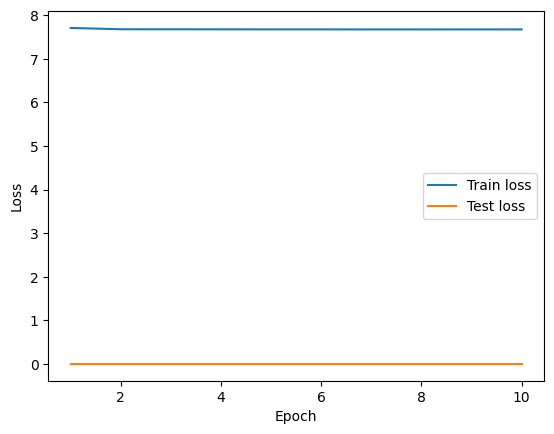

In [107]:
# Plot losses
plt.plot(range(1, epochs + 1), train_losses, label="Train loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# New model
model_name = f"model_{epochs}epochs_{train_losses[-1]:.4f}train_loss_{test_losses[-1]:.4f}test_loss.pth"

# Old model
# model_name = "model_10epochs_0.0000train_loss_0.0000test_loss.pth"

In [ ]:
# Save the model
torch.save(model.state_dict(), "models/" + model_name)

In [ ]:
# Load the model
model = Model()
model.load_state_dict(torch.load("models/" + model_name))
model.to(DEVICE)